In [47]:
# IPython Notebook cell multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Importing Libraries

In [48]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.stattools import adfuller
from matplotlib import pylab as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Loading all dataset

The dataset consists of hourly energy consumption rates in kWh for an industrial utility over a period of around 7 months, from July 2019 to January 2020.



In [49]:
DATASET_FILE = 'energy_model_dataset_anonymized.csv'
dataset = pd.read_csv(f'data/{DATASET_FILE}')


In [50]:
DATE_FORMAT = '%Y-%m-%d %H:%M:%S'
dataset['date'] = dataset['date'].apply(lambda x: datetime.strptime(x, DATE_FORMAT))
dataset.set_index('date', inplace=True)
dataset.head()

,temperature,network,turbine,exchanged,T1,T2,T3,T4,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
date,,,,,,,,,,,,,,,,,,,,
2019-07-09 00:00:00,33.683514,3331.3662,6017.8174,0.0,0.0,719.09670,642.9469,193.18820,60.259495,76.588930,151.03096,27.389202,104.905200,12.328394,49.736450,251.49599,166.14056,421.27975,387.85648,8.473738
2019-07-09 01:00:00,33.374493,3542.0388,6017.8174,0.0,0.0,708.72003,633.3021,197.48200,49.541275,75.434160,156.41446,27.763283,104.823875,11.775405,49.313576,241.81866,166.09177,422.41827,388.18176,8.083392
2019-07-09 02:00:00,36.155697,2867.5225,6180.4614,0.0,0.0,710.34644,634.2780,193.00930,58.974610,75.141396,152.55981,26.543455,104.856410,10.832071,49.085876,240.79404,166.44957,418.72630,384.79877,8.490002
2019-07-09 03:00:00,37.700813,2965.7920,6017.8174,0.0,0.0,708.24835,632.2124,194.21288,54.697083,77.402145,151.66527,25.177246,104.791350,11.791670,49.703920,238.14293,166.62848,421.40988,381.72480,8.180980
2019-07-09 04:00:00,38.530296,3301.7976,6180.4614,0.0,0.0,715.33960,639.0922,191.78947,52.029724,75.775710,150.86832,33.585926,104.823875,12.116957,49.215990,234.79248,166.75860,421.01950,393.63034,8.424944


In [51]:
dataset.shape
# Checking full null values
dataset.isnull().sum()

(4559, 20)

temperature    0
network        0
turbine        0
exchanged      0
T1             0
T2             0
T3             0
T4             0
C1             0
C2             0
C3             0
C4             0
C5             0
C6             0
C7             0
C8             0
C9             0
C10            0
C11            0
C12            0
dtype: int64

In [52]:
# Defining load to predict
LOAD_TO_PREDICT = 'C4'
FREQ = '1H'
ts_data = pd.DataFrame()
ts_data[['energy', 'temperature']] = dataset[[LOAD_TO_PREDICT, 'temperature']]
ts_data.head()

,energy,temperature
date,,
2019-07-09 00:00:00,27.389202,33.683514
2019-07-09 01:00:00,27.763283,33.374493
2019-07-09 02:00:00,26.543455,36.155697
2019-07-09 03:00:00,25.177246,37.700813
2019-07-09 04:00:00,33.585926,38.530296


In [53]:
# Converting Time Series to specified frequency. Filling holes in reindexed Series
ts_data = ts_data.asfreq(FREQ, method='bfill')

In [54]:
ts_data[ts_data['energy'].isnull()]; # Without null values

In [55]:
ts_data.head()

,energy,temperature
date,,
2019-07-09 00:00:00,27.389202,33.683514
2019-07-09 01:00:00,27.763283,33.374493
2019-07-09 02:00:00,26.543455,36.155697
2019-07-09 03:00:00,25.177246,37.700813
2019-07-09 04:00:00,33.585926,38.530296


In [72]:
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res

    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

### Plots Analysis:

- **Augmented Dickey-Fuller Test**: a well known statistical test that can help determine if your time series is stationary (where statistical properties such as mean and variance are constant over time). *A time series is stationary if a single shift in time doesn't change the time series statistical properties, in which case unit root does not exist. The flow directions of any Time Series depends on some ‘characteristic’ directions which are associated with some numerical values called as root value. If the value of these root values is less than equal to 1, convergence will happen else not*.
- **Trend**: a general systematic linear or (most often) nonlinear component that changes over time and does not repeat
- **Autocorrelation(ACF)**: autocorrelation is when a time series is linearly related to a lagged version of itself. Often, one of the first steps in any data analysis is performing regression analysis. However, one of the assumptions of regression analysis is that the data has no autocorrelation. Some time series forecasting methods (specifically regression modeling) rely on the assumption that there isn’t any autocorrelation in the residuals (the difference between the fitted model and the data). *It’s also important to note that the AFC becomes more unreliable as you increase your lag value. This is because you will compare fewer and fewer observations as you increase the lag value. (A general guideline is that the total number of observations (T) should be at least 50, and the greatest lag value (k) should be less than or equal to T/k.)*
- **Partial Autocorrelation(PACF)**: The correlation between observations at two times sports given that we consider both observations are correlated to observations at other time spots. The PACF of yesterday is the "real" correlation between today and yesterday after taking out the influence of the day before yesterday.

In [57]:
def ts_analysis_plots(data, n_lags=100):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions for the loads
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")    

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)
            
    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat
    
    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Date", ylabel="KWh", 
               title=f"Energy consumption over time (ADF p-value: {round(adf[1], 6)})")
        
    # histogram of value distribution
    axs[1].hist(data, bins=20, width = 3, color='#0504aa',alpha=0.7)
    axs[1].set(xlabel="KWh", ylabel="# data points", title="Energy values distribution")
    
    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.show()

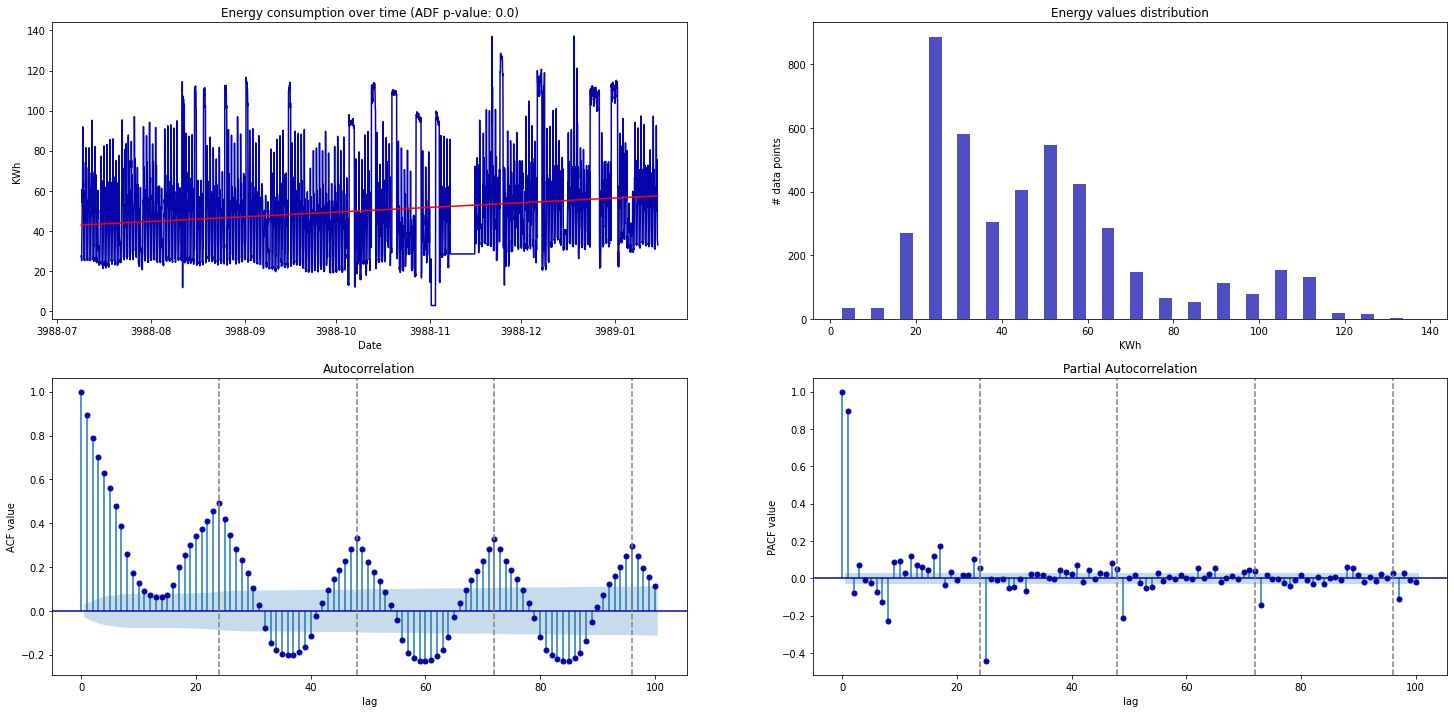

In [58]:
ts_analysis_plots(ts_data["energy"])


### Plot Results

The p-value of the augmented Dick-Fuller (ADF) test, shown in the figure title, is a good indication that the time series is stationary.
From the ACF plot we can observe that the time series has a seasonal component at 24h. In the PACF plot we can confirm the assumption.

## Train and Test

In [71]:
# 2 day forecast
FCAST_STEPS = 48

# seasonal period inferred from the autocorrelation function
SEASONAL_PERIOD = 24

# the complete time series
ts_target = ts_data["energy"]

# data used for training
date = ts_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
t_target = ts_target[ts_target.index <= date]

# data used for forecasting
f_target = ts_target[ts_target.index > date]
fcast_initial_date = f_target.index[0]
fcast_range = pd.date_range(fcast_initial_date, periods=FCAST_STEPS, freq="H")

print(f"Full available time range: from {ts_target.index[0]} to {ts_target.index[-1]}")
print(f"Training time range: from {t_target.index[0]} to {t_target.index[-1]}")
print(f"Short forecasting time range: from {fcast_range[0]} to {fcast_range[-1]}")


Full available time range: from 2019-07-09 00:00:00 to 2020-01-14 23:00:00
Training time range: from 2019-07-09 00:00:00 to 2020-01-12 23:00:00
Short forecasting time range: from 2020-01-13 00:00:00 to 2020-01-14 23:00:00


In [73]:
start_date = t_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)

y_train_trf = TargetTransformer()
y_train = t_target[t_target.index <= start_date]
y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer()
y_test = t_target[t_target.index > start_date]
y_test = y_test_trf.transform(y_test.index, y_test.values)

date
2019-07-09 00:00:00    27.389202
2019-07-09 01:00:00    27.763283
2019-07-09 02:00:00    26.543455
2019-07-09 03:00:00    25.177246
2019-07-09 04:00:00    33.585926
                         ...    
2020-01-10 19:00:00    68.814560
2020-01-10 20:00:00    35.456330
2020-01-10 21:00:00    34.561790
2020-01-10 22:00:00    33.943745
2020-01-10 23:00:00    33.423283
Freq: H, Length: 4464, dtype: float64

## Building Model

In [76]:
from sklearn.preprocessing import StandardScaler, scale
from statsmodels.tsa.stattools import pacf, acf
def create_lag_features(target, lags=None, thres=0.2):
    
    scaler = StandardScaler()
    features = pd.DataFrame()
                
    if lags is None:
        partial = pd.Series(data=pacf(target, nlags=48))
        lags = list(partial[np.abs(partial) >= thres].index)

    df = pd.DataFrame()
    if 0 in lags:
        lags.remove(0) # do not consider itself as lag feature
    for l in lags:
        df[f"lag_{l}"] = target.shift(l)
        
    features = pd.DataFrame(scaler.fit_transform(df[df.columns]), 
                            columns=df.columns)

    features = df
    features.index = target.index
    
    return features

def create_ts_features(data):
    
    def get_shift(row):
        """
        Factory working shift: 3 shifts per day of 8 hours
        """
        if 6 <= row.hour <= 14:
            return 2
        elif 15 <= row.hour <= 22:
            return 3
        else:
            return 1
    
    features = pd.DataFrame()
    
    features["hour"] = data.index.hour
    features["weekday"] = data.index.weekday
    features["dayofyear"] = data.index.dayofyear
    features["is_weekend"] = data.index.weekday.isin([5, 6]).astype(np.int32)
    features["weekofyear"] = data.index.weekofyear
    features["month"] = data.index.month
    features["season"] = (data.index.month%12 + 3)//3
    features["shift"] = pd.Series(data.index.map(get_shift))
    
    features.index = data.index
        
    return features

def create_endog_features(data, extracted=None):
    
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    if extracted is None:
        return features

    # energy consuption of the turbine
    if "turbine" in extracted:
        features["turbine"] = np.where(data["turbine"] > 500, 1, 0)
        extracted.remove("turbine")   

    # all the rest of the features
    for f in extracted:
        features[f] = scale(data[f].values)

    features.index = data.index
    
    return features
lags = create_lag_features(t_target, thres=0.2)
ts = create_ts_features(t_target)
features = ts.join(lags, how="outer").dropna()
target = t_target[t_target.index >= features.index[0]]
features.head()

,hour,weekday,dayofyear,is_weekend,weekofyear,month,season,shift,lag_1,lag_8,lag_25
date,,,,,,,,,,,
2019-07-10 01:00:00,1,2,191,0,28,7,3,1,26.283224,61.625706,27.389202
2019-07-10 02:00:00,2,2,191,0,28,7,3,1,25.567593,74.311910,27.763283
2019-07-10 03:00:00,3,2,191,0,28,7,3,1,25.746500,63.675020,26.543455
2019-07-10 04:00:00,4,2,191,0,28,7,3,1,25.095926,26.950064,25.177246
2019-07-10 05:00:00,5,2,191,0,28,7,3,1,32.691387,26.201904,33.585926
